# Koodos (lite)  — 2Moons Dataset

## Overview
In this notebook, we will demonstrate a **lite version** of the **Koodos** framework, designed to highlight the core idea behind Koodos: how differential equations can help us solve the problem of temporal domain generalization.

The notebook includes:
1. Generate the 2-Moons dataset with continuous concept drift.
2. Implement Koodos.
3. Train the model.
4. Evaluate the model on evolving data domains.

In [1]:
import math
import numpy as np
from sklearn.datasets import make_moons
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib import cm
%matplotlib inline

In [2]:
seed= 2024
device = torch.device('cuda:0')
torch.manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Step 1: Data Generation
We begin by generating the 2-Moons dataset, where the moons rotate continuously over time. The rotation introduces concept drift in the dataset.

We randomly select time points from a continuous time interval. For each selected time point, we apply a rotation to the 2-Moons dataset. In total, we generate 50 different domains. We will use the first 35 domains as training domains and the last 15 as test domains.

#### 1.1 Data Generation

In [3]:
def rotate_data_moon(p, degrees, origin=(0, 0)):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T - o.T) + o.T).T)

def generate_moon(num_domains, samples_per_domain, rotation_per_time):
    time_points = np.sort(np.random.uniform(0, num_domains, num_domains))
    time_points[0] = 0

    datasets = []
    for t in time_points:
        X, y = make_moons(n_samples=samples_per_domain, noise=0.15)
        rotated_data = rotate_data_moon(X, t * rotation_per_time)
        datasets.append((rotated_data, y))
    return datasets, time_points

In [4]:
# Parameters for the dataset
n_domains = 50          # generate 50 different domains
n_train = 35            # the first 35 domains as training domains
n_samples = 1000        # 1000 points for each domain
rotation_per_time = 18  # degrees per unit time

# Generate the data
datasets, time_points = generate_moon(n_domains, n_samples, rotation_per_time)

#### 1.2 Data Visualization

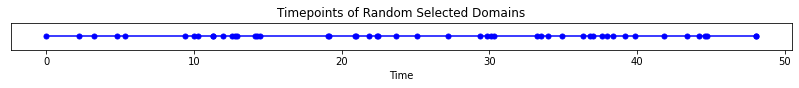

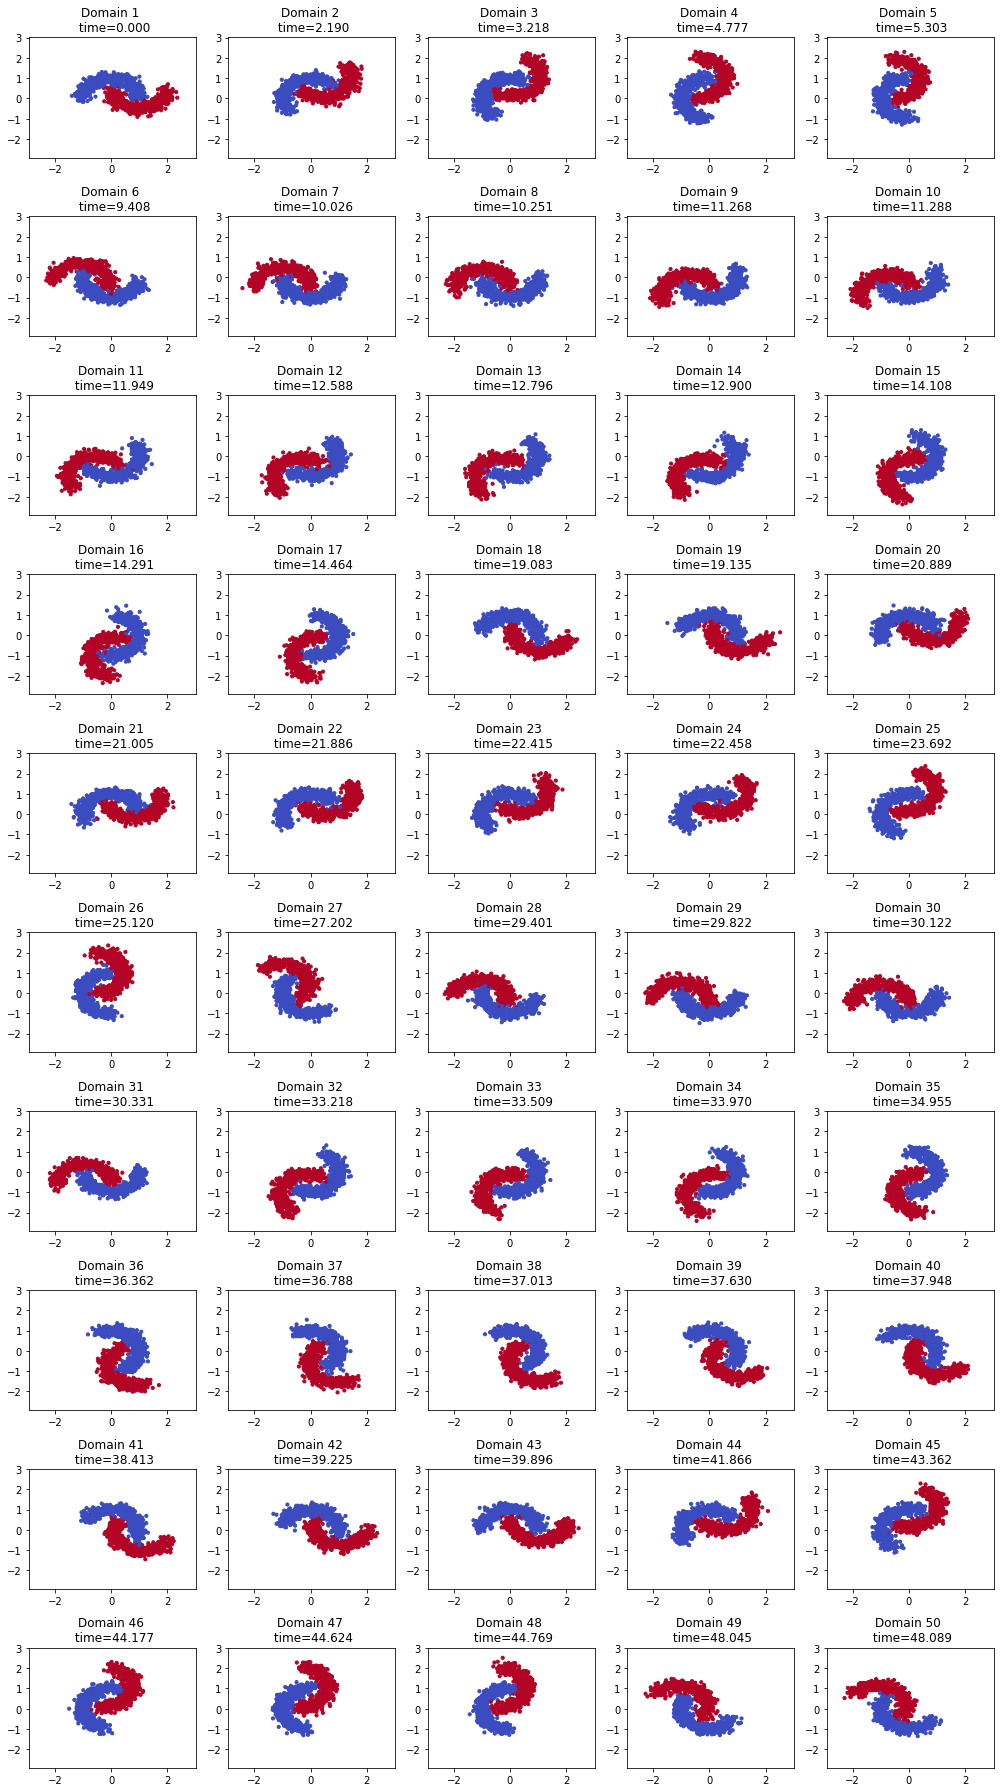

In [5]:
def visualize_moon(datasets, time_points):
    ndomamins = len(time_points)
    ncols = 5
    nrows = math.ceil(ndomamins // ncols)
    
    fig, axs = plt.subplots(figsize=(14, 2.5 * nrows), nrows=nrows, ncols=ncols)
    axs = axs.ravel()

    all_data = np.vstack([data for data, _ in datasets])
    x_min, x_max = all_data[:, 0].min() - 0.5, all_data[:, 0].max() + 0.5
    y_min, y_max = all_data[:, 1].min() - 0.5, all_data[:, 1].max() + 0.5

    for idx, (X_t, y_t) in enumerate(datasets):
        axs[idx].scatter(X_t[:, 0], X_t[:, 1], s=10, c=y_t, cmap="coolwarm")
        axs[idx].set_xlim([x_min, x_max])
        axs[idx].set_ylim([y_min, y_max])
        axs[idx].set_title(f"Domain {idx+1} \n time={time_points[idx]:.3f}")
    plt.tight_layout()
    plt.show()
    
def visualize_time(time_points):
    plt.figure(figsize=(14, 0.5))
    plt.plot(time_points, np.zeros_like(time_points), 'bo-', label="Domains", markersize=5)
    plt.yticks([])
    
    plt.xlabel("Time")
    plt.title("Timepoints of Random Selected Domains")
    plt.show()

visualize_time(time_points)            # visualize moments of randomly selected domains
visualize_moon(datasets, time_points)  # visualize each domain

---

## Step 2: Defining the Koodos

The Koodos framework includes the following key modules:
- **Predictive Models $g(\cdot; \theta_j)$** for each domains that can receive $X_j$ data from dataset and outputs its $Y_j$ label.
- **Encoder $\varphi$ and Decoder $\varphi^{-1}$** that maps the parameters of the Predictive Model to the Koopman Space (KS) and back.
- **Koopman Operator $\mathcal{K}$** that define the dynamics of the parameters of the Predictive Model in KS by a deep neural network.
- **Differential Equation Solver** that computes the integration of dynamics over time to obtain the evolved parameters..

The generalized predictive model parameters $\theta^{j\rightarrow i}_{i}$ for the domain $i$ are derived from the predictive model parameters $\theta_j$ of the domain $j$ ($j<i$) through the following equations:
$$
\begin{align}
z_j &= \varphi(\theta_j) \\
z^{j \rightarrow i}_i &= z_j + \int\nolimits_{t_j}^{t_i} \mathcal{K} z_{\tau} \, d\tau = ODESolve(\mathcal{K}, z_j, t_j, t_i) \\
\theta^{j \rightarrow i}_i &= \varphi^{-1}(z^{j \rightarrow i}_i)
\end{align}
$$

To train Koodos, we need to optimize the following constraints:
- $L_{pred}$: $\theta_j$ works well on domain $j$. 
- $L_{pred2}$: generalized $\theta^{j\rightarrow i}_{i}$ works well on domain $i$. 
- $L_{consis}$: generalized $\theta^{j\rightarrow i}_{i}$ and $\theta_i$ are identical.
- $L_{recon}$: $\theta_j$ and $\varphi^{-1}(\varphi(\theta_j))$ are identical.
- $L_{dyna}$: $z^{j \rightarrow i}_i$ and $z_i$ are identical.

In [6]:
data_dim = 2      # the dimension of the data
model_dim = 2751  # the dimension of the generalized model
embed_dim = 32    # the dimension of the Koopman Space

# Define the Predictive Model, each training domain has a corresponding predictive model
predictive_model = nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()) for i in range(n_train)])

# Define the Generalized Model, it receives the domain data X and the generalized model parameters, then computes the domain data label Y. 
# The model structure is the same as the predictive model.
def generalized_model(domain_x, domain_param):
    m_1 = domain_param[:data_dim * 50]
    b_1 = domain_param[data_dim * 50:data_dim * 50 + 50]
    m_2 = domain_param[data_dim * 50 + 50:data_dim * 50 + 50 + 50 * 50]
    b_2 = domain_param[data_dim * 50 + 50 + 50 * 50:data_dim * 50 + 50 + 50 * 50 + 50]
    m_3 = domain_param[data_dim * 50 + 50 + 50 * 50 + 50:data_dim * 50 + 50 + 50 * 50 + 50 + 50]
    b_3 = domain_param[-1]

    domain_y = torch.sigmoid(F.linear(torch.relu(F.linear(torch.relu(F.linear(domain_x, m_1.reshape((50, data_dim)), b_1)), m_2.reshape((50, 50)), b_2)),m_3.reshape((1, 50)), b_3))
    return domain_y

# Define the Encoder and the Decoder
encoder = nn.Sequential(
            nn.Linear(model_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim))

decoder = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, model_dim))

# Define the Koopman Operator
class ode_f(nn.Module):
    def __init__(self):
        super(ode_f, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim, bias=False))

    def forward(self, t, y):
        return self.net(y)

# Define the ODE Solver, here we choose the fourth-order Runge-Kutta method with a discrete step size of 0.2. 
# A more advanced solver should give better results.
from torchdiffeq import odeint
ode_method = 'rk4'
rk_step = 0.2

> **Tip**: Adding explicit constraints to $\mathcal{K}$ can guide the system toward desired behaviors. Here, if we have a priori knowledge informs us that the concept drift in the data is periodic, then we can configure the $\mathcal{K}$ as $B - B^T$, which will significantly improve the robustness and reliability of the generalized model. To accomplish this uncomment the following code.

In [7]:
# # Define the Koopman Operator with priori knowledge
# class ode_f(nn.Module):
#     def __init__(self):
#         super(ode_f, self).__init__()
#         self.L = nn.Parameter(torch.randn((embed_dim, embed_dim)), requires_grad=True)

#     def forward(self, t, y):
#         K = self.L - self.L.T
#         return torch.matmul(y, K)

In [8]:
# Define the Koodos
class Koodos(nn.Module):
    def __init__(self, time_point):
        super(Koodos, self).__init__()
        self.time_point = time_point

        self.pred_model = predictive_model
        self.gene_model = generalized_model
        self.encoder = encoder
        self.decoder = decoder
        self.odefunc = ode_f()

    # For getting the prediction and parameters from the predictive model
    def predictive_model_pred(self, X, idx, t):
        seg_length = len(t)
        pred, param = [], []
        for i in range(seg_length):
            x = X[i]
            pred.append(self.pred_model[idx + i](x))
            param.append(torch.cat([p.flatten() for p in self.pred_model[idx + i].parameters()]))
        pred, param = torch.cat(pred), torch.stack(param)
        return param, pred

    # For getting the prediction from the generalized model
    def generalized_model_pred(self, X, Gene_Param):
        seg_length = Gene_Param.shape[0]
        pred = []
        for d in range(seg_length):
            x, param = X[d], Gene_Param[d]
            y = self.gene_model(x, param)
            pred.append(y)
        return torch.cat(pred)
    
    def forward(self, X, continous_time=None, idx=0):
        init_param, init_pred = self.predictive_model_pred(X, idx, continous_time)  # theta_j and predictive model prediction
        init_embed = self.encoder(init_param)  # z_j
        gene_embed = odeint(self.odefunc, init_embed[0], continous_time, method=ode_method, options={'step_size': rk_step})  # z^{j \rightarrow i}_i
        gene_param = self.decoder(gene_embed)  # \theta^{j \rightarrow i}_i
        init_debed = self.decoder(init_embed)  # \varphi^{-1}(\varphi(\theta_j))
        gene_pred = self.generalized_model_pred(X, gene_param)  # generalized model prediction
        return init_pred, gene_pred, init_param, init_embed, init_debed, gene_param, gene_embed

## Step 3: Train the Model



In [9]:
# For building the trianing datasets and test datasets
n_train = 35
X = torch.Tensor(np.array([item[0] for item in datasets])).to(device)
Y = torch.Tensor(np.array([item[1] for item in datasets]))[:,:,None].to(device)
time_points = torch.Tensor(time_points).to(device)
X_train, X_text, Y_train, Y_test, time_train, time_test = X[:n_train], X[n_train:], Y[:n_train], Y[n_train:], time_points[:n_train], time_points[n_train:]

Since accurately inferring excessively long sequences for differential equations is time-consuming and cumulative error-intensive, we divide the domain sequence into segments of length up to n_seg, and the integration is performed only on the segments. 

In [10]:
n_seg = 10
train_domain_seg = []
for idx in range(n_train - 1):
    l = min(n_train - idx, n_seg)
    seg_time, seg_X, seg_Y = time_train[idx:idx + l], X_train[idx:idx + l], Y_train[idx:idx + l]
    train_domain_seg.append([seg_time, seg_X, seg_Y])

test_domain_seg = [[time_test, X_text, Y_test]]

In [11]:
EPOCH = 200
BATCH = 4
alpha = 1
beta = 100
gamma = 10

model = Koodos(time_train).to(device)
optimizer = torch.optim.Adam([{'params': model.pred_model.parameters(), 'lr': 1e-2},
                              {'params': model.encoder.parameters(), 'lr': 1e-3},
                              {'params': model.decoder.parameters(), 'lr': 1e-3},
                              {'params': model.odefunc.parameters(), 'lr': 1e-3}])
min_val_loss = np.inf
idx_train_seg = np.arange(len(train_domain_seg), dtype=np.int64)
for epoch in range(EPOCH):
    epoch_loss = 0
    model.train()
    for batch_idx in np.array_split(idx_train_seg, BATCH):
        loss = 0
        for idx in batch_idx:
            seg_time, seg_X, seg_Y = train_domain_seg[idx]

            init_pred, gene_pred, init_param, init_embed, init_debed, gene_param, gene_embed = model(seg_X, seg_time, idx)

            Y = seg_Y.view(-1, 1)
            loss_pred = F.binary_cross_entropy(init_pred, Y)
            loss_pred2 = F.binary_cross_entropy(gene_pred, Y)
            loss_recon = F.mse_loss(init_param, init_debed)
            loss_dyna = F.mse_loss(init_embed, gene_embed)
            loss_consis = F.mse_loss(init_param, gene_param)
            loss = loss + alpha * loss_pred + alpha * loss_pred2 + beta * loss_recon + gamma * loss_dyna + beta * loss_consis

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print('Epoch: {}, Loss: {}'.format(epoch, epoch_loss))

Epoch: 0, Loss: 2621.354595184326
Epoch: 1, Loss: 4647.091747283936
Epoch: 2, Loss: 21505.802392959595
Epoch: 3, Loss: 347.8674488067627
Epoch: 4, Loss: 304.6555938720703
Epoch: 5, Loss: 216.97528266906738
Epoch: 6, Loss: 163.8925552368164
Epoch: 7, Loss: 142.9097194671631
Epoch: 8, Loss: 134.2625274658203
Epoch: 9, Loss: 122.1360855102539
Epoch: 10, Loss: 117.5598373413086
Epoch: 11, Loss: 113.43478679656982
Epoch: 12, Loss: 108.62131690979004
Epoch: 13, Loss: 105.95505332946777
Epoch: 14, Loss: 102.9717960357666
Epoch: 15, Loss: 99.88558387756348
Epoch: 16, Loss: 97.50764083862305
Epoch: 17, Loss: 95.07228660583496
Epoch: 18, Loss: 92.87124538421631
Epoch: 19, Loss: 90.79526329040527
Epoch: 20, Loss: 88.87008285522461
Epoch: 21, Loss: 87.04369926452637
Epoch: 22, Loss: 85.30123233795166
Epoch: 23, Loss: 83.68496704101562
Epoch: 24, Loss: 82.19189643859863
Epoch: 25, Loss: 80.8202657699585
Epoch: 26, Loss: 79.58813571929932
Epoch: 27, Loss: 78.45028877258301
Epoch: 28, Loss: 77.482514

> **Note**: Validation sets should be added to the formal Koodos. 

---

## Step 4. Test the Model and Visualization

In [12]:
# Generalize models fot future test domains from the last training domain
last_param = torch.cat([p.flatten() for p in model.pred_model[-1].parameters()])
last_time = model.time_point[-1:]
final_time_test = torch.cat([last_time, time_test])

last_embed = model.encoder(last_param)
test_embed = odeint(model.odefunc, last_embed, final_time_test, method=ode_method, options={'step_size': rk_step})[1:]
test_param = model.decoder(test_embed)
test_pred = model.generalized_model_pred(X_text, test_param).reshape_as(Y_test)

In [13]:
# Test the performance
test_pred_flatten, Y_flatten = test_pred.view(-1, 1), Y_test.view(-1, 1)
prediction = torch.as_tensor((test_pred_flatten.detach() - 0.5) > 0).float()
accuracy = (prediction.squeeze(-1) == Y_flatten.squeeze(-1)).float().sum() / prediction.shape[0]
print('All Accuracy {:.2%}\n'.format(accuracy))

for i in range(X_text.shape[0]):
    test_pred_step, Y_test_step = test_pred[i], Y_test[i]
    prediction = torch.as_tensor((test_pred_step.detach() - 0.5) > 0).float()
    accuracy = (prediction.squeeze(-1) == Y_test_step.squeeze(-1)).float().sum() / prediction.shape[0]
    print('Step {}, Accuracy {:.2%}'.format(i + 1, accuracy))

All Accuracy 74.65%

Step 1, Accuracy 84.30%
Step 2, Accuracy 78.20%
Step 3, Accuracy 74.20%
Step 4, Accuracy 65.50%
Step 5, Accuracy 63.50%
Step 6, Accuracy 59.40%
Step 7, Accuracy 59.30%
Step 8, Accuracy 71.00%
Step 9, Accuracy 86.00%
Step 10, Accuracy 86.90%
Step 11, Accuracy 89.40%
Step 12, Accuracy 89.40%
Step 13, Accuracy 89.00%
Step 14, Accuracy 61.60%
Step 15, Accuracy 62.10%


### Visualize the boundary of the test domain 

In [14]:
def plot_decision_boundary(model, ax, param, data=None, t=0, ani=False):
    h = .02
    x_min, x_max = -2.5, 2.5
    y_min, y_max = -2.5, 2.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.generalized_model_pred(torch.tensor([np.c_[xx.ravel(), yy.ravel()]], dtype=torch.float32).to(device), param)
    Z = Z.detach().cpu().numpy()
    Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    if ani:
        im1 = ax.contourf(xx, yy, Z, alpha=0.3)
        im2 = ax.text(1, -2, 'time = {:.2f}'.format(t))
        return im1.collections + [im2]
    else:
        ax.contourf(xx, yy, Z, alpha=0.3)
        ax.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2)
        if data:
            X, Y = data
            scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.coolwarm, alpha=0.2)
            
        ax.tick_params(axis='both', which='both', width=2, labelsize=11)
        for spine in ax.spines.values():
            spine.set_linewidth(1.6)

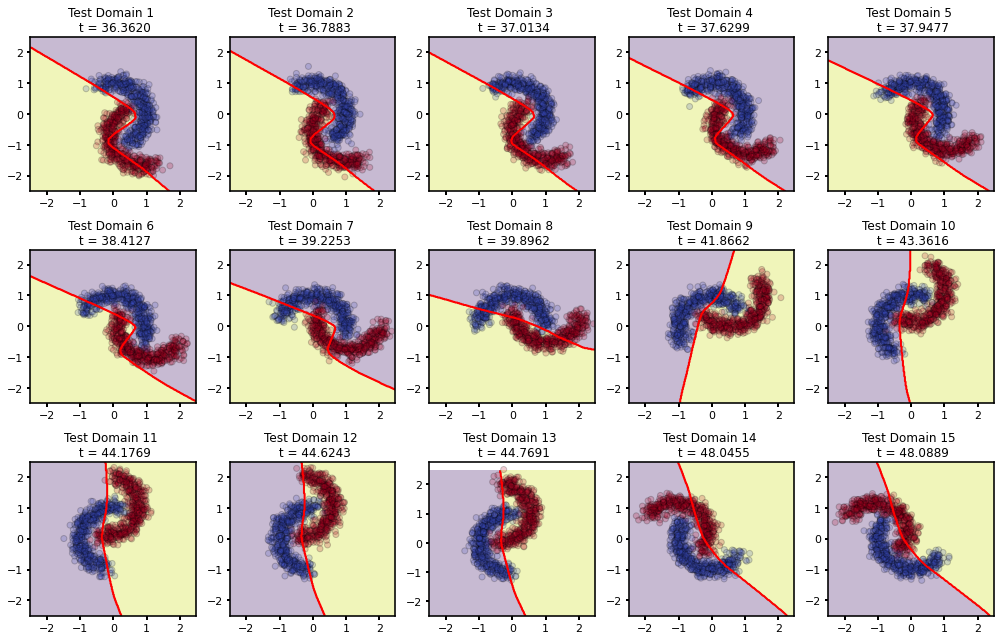

In [15]:
test_tasks = X_text.shape[0]
fig, axs = plt.subplots(math.ceil(test_tasks // 5), 5, figsize=(14, 3 * math.ceil(test_tasks // 5)))
axs = axs.ravel()
for i in range(test_tasks):
    plot_decision_boundary(model, axs[i], test_param[i:i+1], [X_text[i].cpu().numpy(), Y_test[i].cpu().numpy()])
    axs[i].set_title('Test Domain {} \n t = {:.4f}'.format(i+1, time_test[i].item()))
plt.tight_layout()

---

**Besides testing on randomly generated test domains, we can also interpolate the state of the model at ANY moment to check the continuity of the generalized model.**

### First we check the generalization results by visualizing the boundary.

In [16]:
# Generate Interpolation Timepoints
inter_seg_time = []
insert_time = 0
for idx, i in enumerate(time_train[:-1]):
    seg = [time_train[idx].item()]
    while insert_time + rk_step <= time_train[idx + 1]:
        insert_time += rk_step
        seg.append(insert_time)
    if len(seg) > 1:
        inter_seg_time.append([idx, seg])
inter_seg_time

[[0,
  [0.0,
   0.2,
   0.4,
   0.6000000000000001,
   0.8,
   1.0,
   1.2,
   1.4,
   1.5999999999999999,
   1.7999999999999998,
   1.9999999999999998]],
 [1,
  [2.1904282569885254,
   2.1999999999999997,
   2.4,
   2.6,
   2.8000000000000003,
   3.0000000000000004,
   3.2000000000000006]],
 [2,
  [3.218184471130371,
   3.400000000000001,
   3.600000000000001,
   3.800000000000001,
   4.000000000000001,
   4.200000000000001,
   4.400000000000001,
   4.600000000000001]],
 [3,
  [4.7771077156066895,
   4.800000000000002,
   5.000000000000002,
   5.200000000000002]],
 [4,
  [5.303143501281738,
   5.400000000000002,
   5.600000000000002,
   5.8000000000000025,
   6.000000000000003,
   6.200000000000003,
   6.400000000000003,
   6.600000000000003,
   6.800000000000003,
   7.0000000000000036,
   7.200000000000004,
   7.400000000000004,
   7.600000000000004,
   7.800000000000004,
   8.000000000000004,
   8.200000000000003,
   8.400000000000002,
   8.600000000000001,
   8.8,
   9.0,
   9.2,
 

In [17]:
# Generate Extrapolation Timepoints
last_t = model.time_point[-1].item()
seg = [last_t]
for i in np.arange(last_t // rk_step * rk_step + rk_step, 70, rk_step):
    seg.append(i)
extra_seg_time = [[n_train - 1, seg]]
extra_seg_time

[[34,
  [34.95543670654297,
   35.00000000000001,
   35.20000000000001,
   35.40000000000001,
   35.600000000000016,
   35.80000000000002,
   36.00000000000002,
   36.200000000000024,
   36.40000000000003,
   36.60000000000003,
   36.80000000000003,
   37.000000000000036,
   37.20000000000004,
   37.40000000000004,
   37.600000000000044,
   37.80000000000005,
   38.00000000000005,
   38.20000000000005,
   38.400000000000055,
   38.60000000000006,
   38.80000000000006,
   39.000000000000064,
   39.20000000000007,
   39.40000000000007,
   39.60000000000007,
   39.800000000000075,
   40.00000000000008,
   40.20000000000008,
   40.400000000000084,
   40.60000000000009,
   40.80000000000009,
   41.00000000000009,
   41.200000000000095,
   41.4000000000001,
   41.6000000000001,
   41.800000000000104,
   42.00000000000011,
   42.20000000000011,
   42.40000000000011,
   42.600000000000115,
   42.80000000000012,
   43.00000000000012,
   43.200000000000124,
   43.40000000000013,
   43.6000000000

In [18]:
def generalize_model(model, idx, time_seg, return_idx=False):
    idx_param = torch.cat([p.flatten() for p in model.pred_model[idx].parameters()])
    idx_embed = model.encoder(idx_param)
    gene_embed = odeint(model.odefunc, idx_embed, time_seg, method='rk4', options={'step_size': rk_step})
    gene_param = model.decoder(gene_embed)

    s = 0 if return_idx else 1
    return gene_param[s:], time_seg[s:]

In [19]:
inter_param, inter_time = [], []
for idx, time_seg in inter_seg_time:
    time_seg = torch.Tensor(time_seg).to(device)
    gene_param, gene_time = generalize_model(model, idx, time_seg)
    inter_param.append(gene_param)
    inter_time.append(gene_time.cpu().numpy())
inter_param, inter_time = torch.cat(inter_param), np.concatenate(inter_time)

extra_param, extra_time = [], []
for idx, time_seg in extra_seg_time:
    time_seg = torch.Tensor(time_seg).to(device)
    gene_param, gene_time = generalize_model(model, idx, time_seg)
    extra_param.append(gene_param)
    extra_time.append(gene_time.cpu().numpy())
extra_param, extra_time = torch.cat(extra_param), np.concatenate(extra_time)

In [20]:
genelize_time = np.concatenate([inter_time, extra_time])
generalize_param = torch.cat([inter_param, extra_param])

Check the generalization results in the *model_generalization.gif* file generated in the same directory

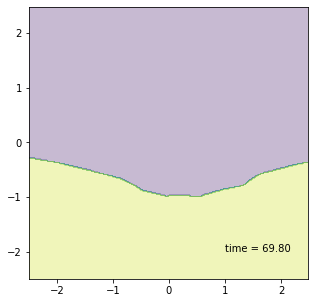

In [21]:
## Plot
figures = []
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
for i in range(len(genelize_time)):
    img = plot_decision_boundary(model, ax, generalize_param[i:i + 1], t=genelize_time[i], ani=True)
    figures.append(img)
ani = animation.ArtistAnimation(fig, figures, interval=100, blit=True, repeat_delay=5000)
ani.save('model_generalization.gif', writer='pillow')

### Second we check the evolutionary trajectory of the model in the hidden space.

In [22]:
# For getting the model parameters of training domains
train_param = []
for i in range(len(model.pred_model)):
    train_param.append(torch.cat([p.flatten() for p in model.pred_model[i].parameters()]))
train_param, train_time = torch.stack(train_param), model.time_point.cpu().numpy()

In [23]:
# Reduce dimensionality
embed_method = 'tsne'
model_traj = np.concatenate([train_param.detach().cpu().numpy(), inter_param.detach().cpu().numpy(), extra_param.detach().cpu().numpy()], axis=0)
model_traj = TSNE(n_components=2, init='random', random_state=seed).fit_transform(model_traj)

In [24]:
def plot_model_trajectory(ax, model_traj, time):
    train_z, inter_z, extra_z = time
    
    n_train = len(train_z)
    n_inter = len(inter_z)
    n_extra = len(extra_z)
    
    ax.scatter(model_traj[:n_train, 0], model_traj[:n_train, 1], zs=train_z, c='blue', label='Train', s=60)

    inter_points = model_traj[n_train:n_train + n_inter]
    colors = cm.viridis(np.linspace(0, 1, n_inter))
    for i in range(n_inter - 1):
        line = art3d.Line3D([inter_points[i, 0], inter_points[i+1, 0]],
                            [inter_points[i, 1], inter_points[i+1, 1]],
                            [inter_z[i], inter_z[i+1]], 
                            linewidth=3.5, color=colors[i])
        ax.add_line(line)

    extra_points = model_traj[n_train + n_inter:]
    ax.plot(extra_points[:, 0], extra_points[:, 1], 
            zs=extra_z, c='red', linewidth=3.5)

    ax.tick_params(axis='both', which='both', width=2, labelsize=11)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    ax.tick_params(axis='both', which='major', labelsize=12, width=3, length=6)
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)

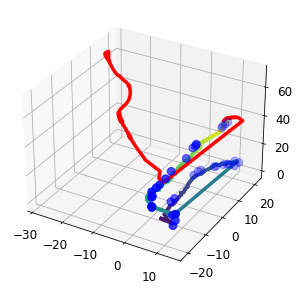

In [25]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
plot_model_trajectory(ax, model_traj, [train_time, inter_time, extra_time])